In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import load

In [2]:
X_train, X_test, y_train, y_test = load('../../preprocesiranje/classification_data.joblib')

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from termcolor import colored

In [4]:
def model_info(y_real, y_pred):
    # mere kvaliteta
    print(classification_report(y_real, y_pred))
    
    # matrica konfuzije
    y_true = np.array(y_real)
    y_pred = np.array(y_pred)

    # kreiranje matrice konfuzije
    conf_matrix = confusion_matrix(y_true, y_pred)

    # kreiranje heatmap-e za matricu konfuzije
    plt.figure(figsize = (3, 3))
    class_names = [-1, 0, 1]
    sns.heatmap(conf_matrix, annot = True, cmap = 'Reds', fmt = 'd', cbar = True, xticklabels = class_names, yticklabels = class_names)
    plt.xlabel('Predict values')
    plt.ylabel('Real values')
    plt.title('Confusion matrix')
    plt.show()

In [5]:
def build_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    return model, y_train_pred, y_test_pred

# K - najbližih suseda

In [6]:
from sklearn.neighbors import KNeighborsClassifier

In [7]:
knn = KNeighborsClassifier()

In [8]:
knn_model, y_train_pred_knn, y_test_pred_knn = build_model(knn, X_train, X_test, y_train, y_test)

Train data:

              precision    recall  f1-score   support

          -1       0.83      0.83      0.83       268
           0       0.81      0.87      0.84       334
           1       0.94      0.86      0.90       338

    accuracy                           0.86       940
   macro avg       0.86      0.85      0.85       940
weighted avg       0.86      0.86      0.86       940



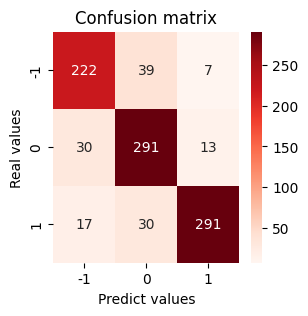


-------------------------------------------------------

Test data:

              precision    recall  f1-score   support

          -1       0.75      0.83      0.79        58
           0       0.79      0.82      0.81        94
           1       0.91      0.81      0.85        83

    accuracy                           0.82       235
   macro avg       0.82      0.82      0.82       235
weighted avg       0.82      0.82      0.82       235



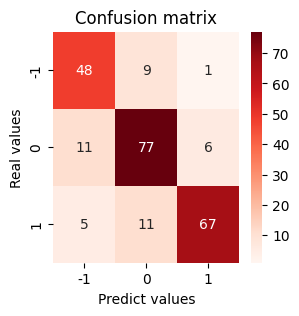

In [9]:
print('Train data:\n')
model_info(y_train, y_train_pred_knn)

print('\n-------------------------------------------------------\n')

print('Test data:\n')
model_info(y_test, y_test_pred_knn)

Iako model pravi "dosta" grešaka prilikom klasiifikacije, uspeva da održi sličan nivo preciznosti i odziva na test skupu kao na trening skupu. 

### Podešavanje hiper-parametara modela

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
params = {
    'n_neighbors': [1, 5, 10, 20, 22],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

In [12]:
estimator_knn = GridSearchCV(KNeighborsClassifier(), param_grid = params)

In [13]:
estimator_knn.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5, 10, 20, 22], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [14]:
estimator_knn.best_params_

{'n_neighbors': 22, 'p': 1, 'weights': 'distance'}

In [15]:
estimator_knn.best_score_

0.8404255319148936

In [16]:
best_model_knn, y_train_pred_knncv, y_test_pred_knncv = build_model(estimator_knn.best_estimator_, X_train, X_test, y_train, y_test)

Train data:

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       268
           0       1.00      1.00      1.00       334
           1       1.00      1.00      1.00       338

    accuracy                           1.00       940
   macro avg       1.00      1.00      1.00       940
weighted avg       1.00      1.00      1.00       940



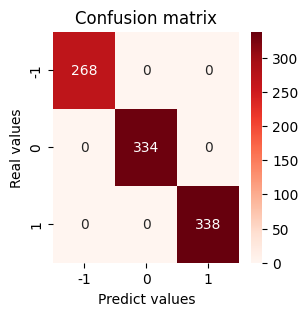


-------------------------------------------------------

Test data:

              precision    recall  f1-score   support

          -1       0.82      0.86      0.84        58
           0       0.81      0.86      0.84        94
           1       0.92      0.82      0.87        83

    accuracy                           0.85       235
   macro avg       0.85      0.85      0.85       235
weighted avg       0.85      0.85      0.85       235



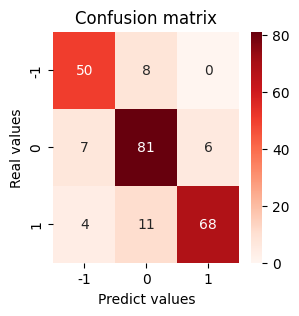

In [17]:
print('Train data:\n')
model_info(y_train, y_train_pred_knncv)

print('\n-------------------------------------------------------\n')

print('Test data:\n')
model_info(y_test, y_test_pred_knncv)

Na trening skupu, model postiže savršene rezultate za sve tri klase (-1, 0, 1), sugerišući da je naučio svaki detalj skupa za obuku i klasifikovao instance s visokom preciznošću i odzivom. Međutim, ovi rezultati nisu reproducibilni na test skupu, gdje dolazi do smanjenja performansi. Naš model se preprilagodion trening podacima.

# Poređenje modela

### ROC kriva

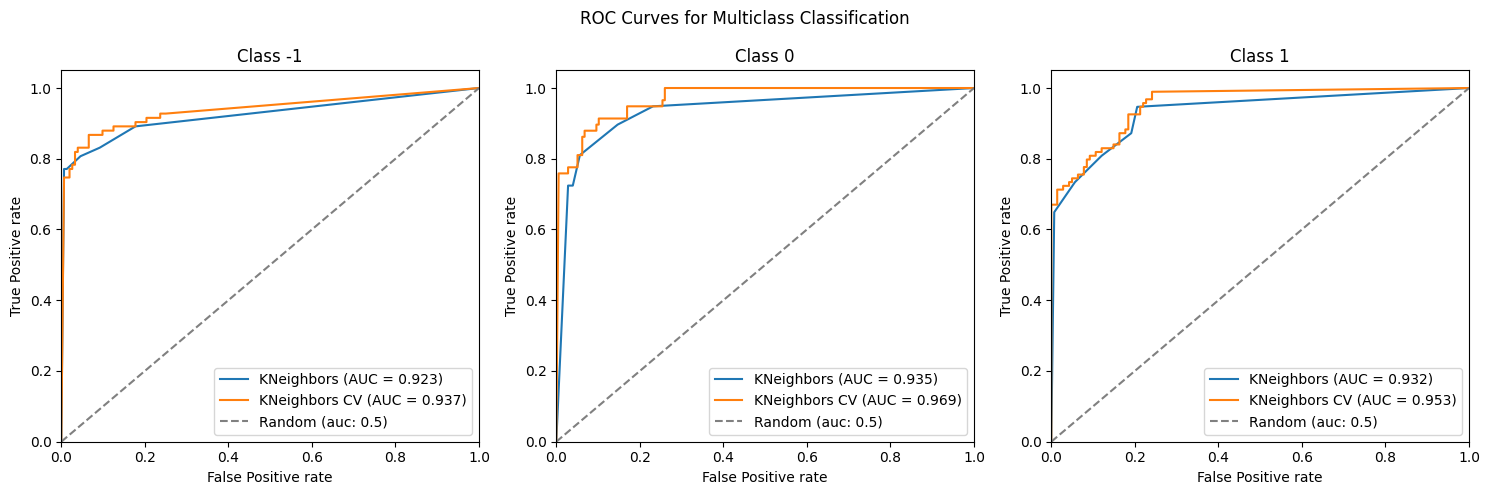

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# binarizacija ciljnih vrednosti (zbog višeklasne klasifikacije)
y_train_bin = label_binarize(y_train, classes = [-1, 0, 1])
y_test_bin = label_binarize(y_test, classes = [-1, 0, 1])

# definisanje modela i imena modela
models = [knn_model, best_model_knn]
model_names = ['KNeighbors', 'KNeighbors CV']

# inicijalizacija grafa
plt.figure(figsize = (15, 5))

# petlja za svaku klasu
for class_index in range(y_train_bin.shape[1]):
    # prikazivanje svake klase u odvojenom subplotu
    plt.subplot(1, y_train_bin.shape[1], class_index + 1)  
    plt.title(f'Class {class_index - 1}')
    
    # petlja za svaki model
    for model, model_name in zip(models, model_names):
        # izračunavanje vrednosti za ROC krivu i AUC
        y_pred = model.predict_proba(X_test) # Probabilities for positive class
   
        fpr, tpr, _ = roc_curve(y_test_bin[:, class_index-1],  y_pred[:, class_index-1])
        roc_auc = auc(fpr, tpr)

        # prikazivanje ROC krive za svaki model
        plt.plot(fpr, tpr, label = f'{model_name} (AUC = {roc_auc:.3f})')
        
    plt.plot([0, 1], [0, 1], label = 'Random (auc: 0.5)', color = 'grey', linestyle='--')
    
    # podešavanje osa za svaki subplot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive rate')
    plt.ylabel('True Positive rate')
    plt.legend()

plt.suptitle('ROC Curves for Multiclass Classification')
plt.tight_layout()
plt.show()

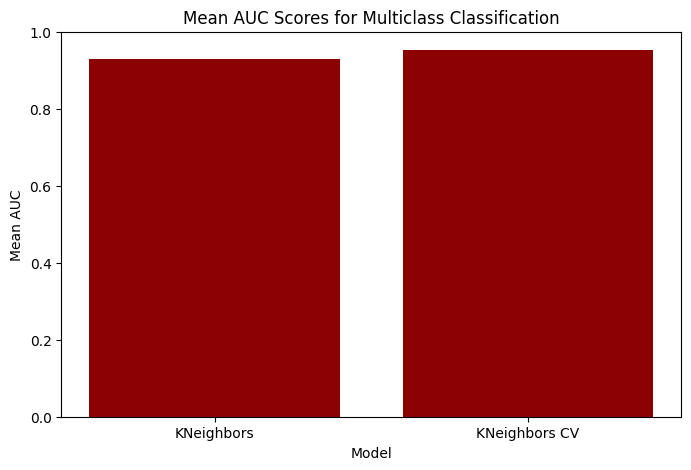

In [19]:
# izračunavanje usrednjenih AUC vrednosti za svaki model
mean_auc_scores = []

for model in models:
    y_pred = model.predict_proba(X_test)
    
    auc_scores = []
    for class_index in range(y_train_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, class_index-1], y_pred[:, class_index-1])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
    
    mean_auc_scores.append(np.mean(auc_scores))

# vizualizacija usrednjene AUC vrednosti
plt.figure(figsize = (8, 5))
plt.bar(model_names, mean_auc_scores, color = 'darkred')
plt.xlabel('Model')
plt.ylabel('Mean AUC')
plt.title('Mean AUC Scores for Multiclass Classification')
plt.show()

### Granice odluka

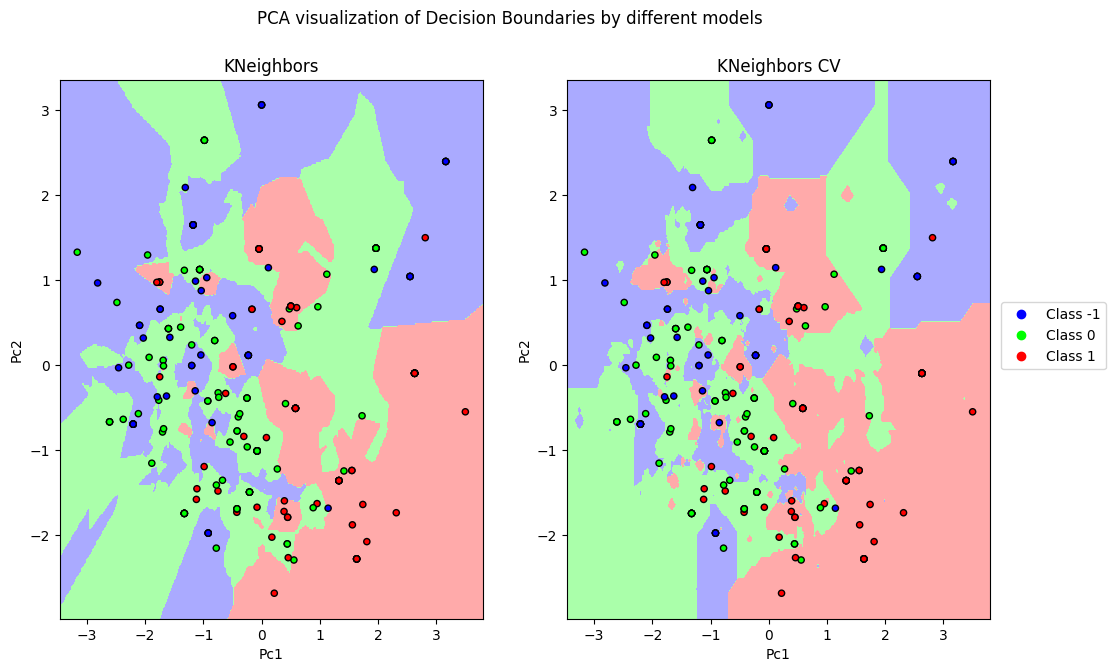

In [20]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# pca model
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# definirajte različite kombinacije parametara za k-NN algoritam
param_combinations = [
    {'n_neighbors': 5,  'weights': 'uniform',  'p': 2},    # default model
    {'n_neighbors': 10, 'weights': 'distance', 'p': 1}     # best model
]

fig, axs = plt.subplots(1, 2, figsize = (12, 7))
for i in range(2):
    # pronalaženje odgovarajućih parametara
    params = param_combinations[i]  
    
    n_neighbors = params['n_neighbors']
    weights = params['weights']
    p = params['p']


    knnP = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights, p = p)
    knnP.fit(X_train_pca, y_train)

    h = 0.02
    x_min, x_max = X_test_pca[:, 0].min() - 0.3, X_test_pca[:, 0].max() + 0.3
    y_min, y_max = X_test_pca[:, 1].min() - 0.3, X_test_pca[:, 1].max() + 0.3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = knnP.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_background = ListedColormap(['#AAAAFF', '#AAFFAA', '#FFAAAA'])
    cmap_boundary = ListedColormap(['#0000FF', '#00FF00', '#FF0000'])

    axs[i].contourf(xx, yy, Z, cmap = cmap_background)
    scatter = axs[i].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c = y_test, cmap = cmap_boundary, edgecolors = 'k', s = 20)
    axs[i].set_title(f'{model_names[i]}')
    axs[i].set_xlabel('Pc1')
    axs[i].set_ylabel('Pc2')

    
fig.legend(handles = scatter.legend_elements()[0], labels=['Class -1', 'Class 0', 'Class 1'], loc = 'center right')
plt.suptitle('PCA visualization of Decision Boundaries by different models')
plt.show()

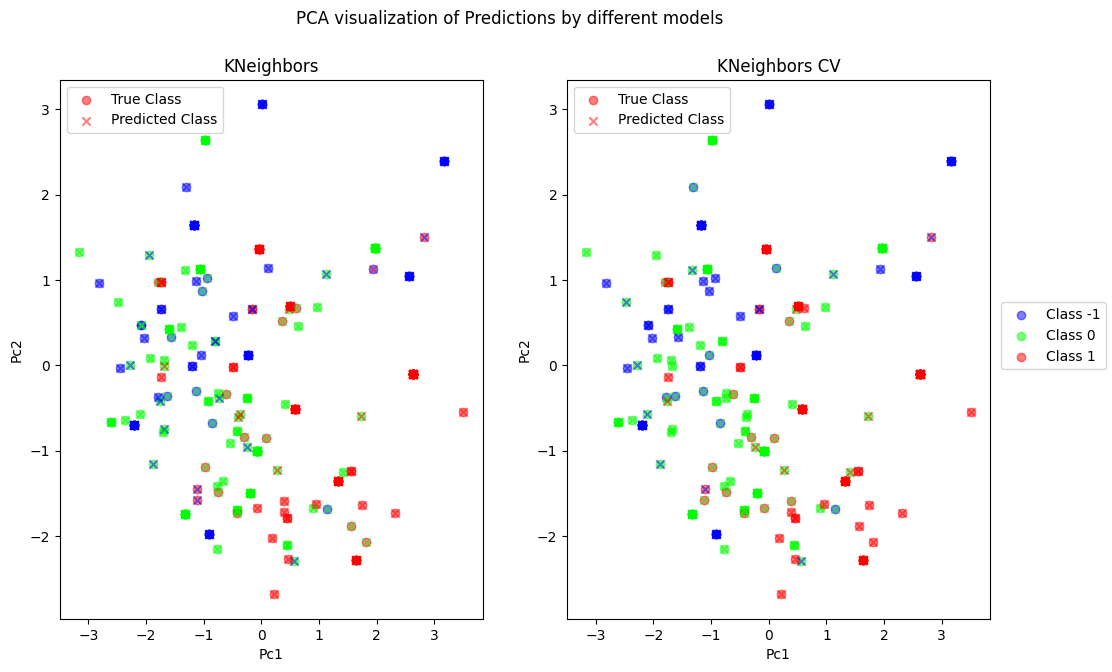

In [21]:
colors = {-1: '#0000FF', 0: '#00FF00', 1: '#FF0000'}

y_preds = [y_test_pred_knn, y_test_pred_knncv]

fig, axes = plt.subplots(1, 2, figsize = (12, 7))
for col in range(2):
    model_idx = col

    ax = axes[col]
    y_pred = y_preds[model_idx]
    model_name = model_names[model_idx]

    # stvaranje scatter plot-a za stvarne klase (kružići)
    for class_label in np.unique(y_test):
        class_mask = y_test == class_label
        ax.scatter(X_test_pca[class_mask, 0], X_test_pca[class_mask, 1], c = colors[class_label], marker = 'o', label=f'True Class', alpha = 0.5)

    # stvaranje scatter plot-a za predviđene klase (x)
    for class_label in np.unique(y_pred):
        class_mask = y_pred == class_label
        ax.scatter(X_test_pca[class_mask, 0], X_test_pca[class_mask, 1], c = colors[class_label], marker = 'x', label=f'Predicted Class', alpha = 0.5)

    ax.set_title(f'{model_name}')
    ax.set_xlabel('Pc1')
    ax.set_ylabel('Pc2')

    # dodavanje legende na prvi subplot (axes[0])
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc = 'upper left')

# dodavanje opisa boja za svaku klasu na cijelu figuru
legend_labels = [f'Class {class_label}' for class_label in colors]
fig.legend(legend_labels, loc = 'right')

plt.suptitle('PCA visualization of Predictions by different models')
plt.show()

# Čuvanje modela

In [22]:
from joblib import dump

In [23]:
dump(models, 'kNeighbors.joblib')

['kNeighbors.joblib']